# Grover's Search Algorithm Code

In [ ]:
# Install amazon-braket-sdk
!pip install amazon-braket-sdk


In [3]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

## Libraries and Parameters <a name="setup"></a>

In [4]:
# Import Braket libraries
from braket.circuits import circuit, Circuit
from braket.aws import AwsQuantumTask, AwsDevice
from braket.devices import Devices, LocalSimulator
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import numpy as np

## Helper Functions <a name="wrappers"></a>

We develop a set of useful helper functions that we will explain in detail below. Specifically, we provide simple building blocks for the four core modules of Grover's search algorithm: 1) initialization, 2) oracle, 3) amplification, and 4) measurement. This approach allows us to solve the problem in a clean and modular way.

In [5]:
# Helper function to build C-C-Z gate
@circuit.subroutine(register=True)
def ccz(targets=[0, 1, 2]):
    """
    implementation of three-qubit gate CCZ
    """
    # define three-qubit CCZ gate
    ccz_gate = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0]],
                       dtype=complex)

    # instantiate circuit object
    circ = Circuit()

    # add CCZ gate
    circ.unitary(matrix=ccz_gate, targets=targets)

    return circ


# All possible items and their corresponding oracles
# define oracle dictionary using this CCZ gate
oracle_sim = {"000": Circuit().x([0,1,2]).ccz(targets=[0, 1, 2]).x([0,1,2]),
              "001": Circuit().x([0,1]).ccz(targets=[0, 1, 2]).x([0,1]),
              "010": Circuit().x([0,2]).ccz(targets=[0, 1, 2]).x([0,2]),
              "011": Circuit().x([0]).ccz(targets=[0, 1, 2]).x([0]),
              "100": Circuit().x([1,2]).ccz(targets=[0, 1, 2]).x([1,2]),
              "101": Circuit().x([1]).ccz(targets=[0, 1, 2]).x([1]),
              "110": Circuit().x([2]).ccz(targets=[0, 1, 2]).x([2]),
              "111": Circuit().ccz(targets=[0, 1, 2])
          }


# helper function for initialization
def initialize(n_qubits=3):
    """
    function to apply hadamard to all qubits
    """
    # Initialize with superposition
    circ = Circuit();
    circ.h(np.arange(n_qubits))
    #print(circ)
    return circ


# helper function for phase oracle
def oracle(item):
    """
    function to apply oracle for given target item
    """
    # instantiate circuit object
    circ = Circuit()

    # add oracle
    circ.add_circuit(oracle_sim[item])

    return circ


# helper function for amplification
def amplify(n_qubits=3):
    """
    function for amplitude amplification
    """
    # instantiate circuit object
    circ = Circuit()

    # Amplification
    circ.h(np.arange(n_qubits))
    circ.add_circuit(oracle_sim['000'])
    circ.h(np.arange(n_qubits))

    return circ


# helper function for grover algorithm
def grover(item, n_qubits=3, n_reps=1):
    """
    function to put together individual modules of Grover algorithm
    """
    # initialize
    grover_circ = initialize()
    # oracle and amplify
    for ii in range(n_reps):
        # get oracle
        or_circ = oracle(item)
        grover_circ.add(or_circ)
        # amplify
        amplification = amplify()
        grover_circ.add(amplification)

    return grover_circ


In [6]:
# Function to run quantum task, check the status thereof, and collect results
def get_result(circ):

    # get number of qubits
    num_qubits = circ.qubit_count

    # specify desired results_types
    circ.probability()

    # submit quantum task: define quantum task (asynchronous)
    task = device.run(circ, shots=1000)

    # Get ID of submitted quantum task
    task_id = task.id
#     print('Task ID :', task_id)

    # Wait for hybrid job to complete
    status_list = []
    status = task.state()
    status_list += [status]
    print('Status:', status)

    # Only notify the user when there's a status change
    while status != 'COMPLETED':
        status = task.state()
        if status != status_list[-1]:
            print('Status:', status)
        status_list += [status]

    # get result
    result = task.result()

    # get metadata
    metadata = result.task_metadata

    # get output probabilities
    probs_values = result.values[0]

    # get measurement results
    measurement_counts = result.measurement_counts

    # print measurement results
    print('measurement_counts:', measurement_counts)

    # bitstrings
    format_bitstring = '{0:0' + str(num_qubits) + 'b}'
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

    # plot probabalities
    plt.bar(bitstring_keys, probs_values);
    plt.xlabel('bitstrings');
    plt.ylabel('probability');
    plt.xticks(rotation=90);

    return measurement_counts

## Device: Classical Simulator <a name="sim_c"></a>
We demonstrate Grover's algorithm on a classical simulator first.
You can choose between a local simulator or an on-demand simulator.
In the next section, we will run the same problem on a quantum IonQ device.

In [7]:
# Set up the cloud-based simulator
# device = AwsDevice(Devices.Amazon.SV1)

# set up the local simulator
device = LocalSimulator()

In [8]:
# get device name
device_name = device.name
# show the properties of the device
device_properties = device.properties
# show supportedQuantumOperations (supported gates for a device)
device_operations = device_properties.dict()['action']['braket.ir.jaqcd.program']['supportedOperations']
# Note: This field also exists for other devices like the QPUs
print('Quantum Gates supported by {}:\n {}'.format(device_name, device_operations))

Quantum Gates supported by StateVectorSimulator:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cv', 'cy', 'cz', 'ecr', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']


Since the ```CCZ``` gate is not part of the default gate set, we have used the ```unitary``` method to build a custom, doubly-controlled Z gate ```CCZ``` for the phase oracle operator.
We will leverage the Amazon Braket `circuit.subroutine` functionality, which allows us to use such a custom-built gate as if it were any other built-in gate.  

Now, we are ready to run our circuit for a few test cases.
To recap, the steps are as follows:

1. Create a uniform superposition
2. Apply the phase oracle corresponding to our target item
3. Define the diffusion operator to magnify the amplitude difference created by the oracle
4. Collect the measurement counts for our target item

T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │
      ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ 
q0 : ─┤ H ├─┤ U ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └─┬─┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ U ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └─┬─┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q2 : ─┤ H ├─┤ U ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │
Status: COMPLETED
measurement_counts: Counter({'111': 799, '100': 35, '010': 33, '000': 32, '101': 29, '001': 27, '011': 27, '110': 18})


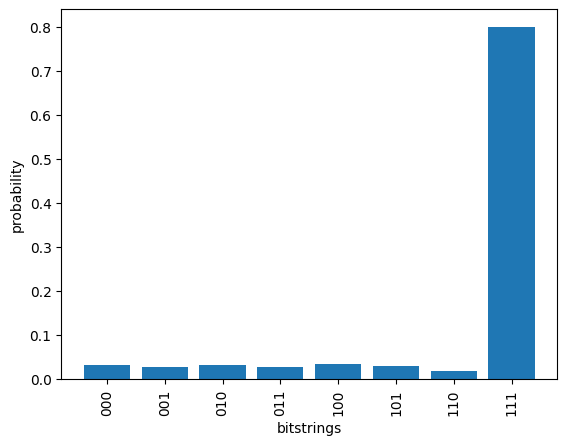

In [9]:
# Select item to find. Let's start with '111' for now
item = "111"

# get Grover circuit
circ = grover(item)

# print circuit
print(circ)

# Measurement
counts = get_result(circ)

__DISCUSSION__: We observe a strong peak around the target solution given by the `111` bitstring, with all other bitstrings showing far smaller probabilities.
Let us try one more item:

T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │
      ┌───┐       ┌───┐ ┌───┐ ┌───┐       ┌───┐ ┌───┐ ┌───┐ 
q0 : ─┤ H ├───────┤ U ├─┤ H ├─┤ X ├───────┤ U ├─┤ X ├─┤ H ├─
      └───┘       └─┬─┘ └───┘ └───┘       └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └───┘ └─┬─┘ └───┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q2 : ─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │
Status: COMPLETED
measurement_counts: Counter({'100': 796, '111': 32, '010': 32, '000': 31, '001': 28, '011': 28, '101': 28, '110': 25})


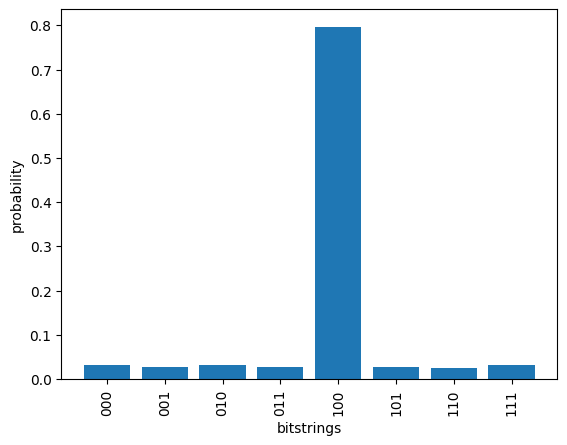

In [10]:
# Select item to find. Let's start with '111' for now
item = "100"

# get Grover circuit
circ = grover(item)

# print circuit
print(circ)

# Measurement
counts = get_result(circ)

__DISCUSSION__: By repeating steps 2 (oracle) and 3 (amplification), we can further magnify the amplitude of the target item, thus maximizing the single-shot probability of identifying the right answer. This repetition is demonstrated below.

T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │  9  │ 10  │ 11  │ 12  │ 13  │ 14  │ 15  │ 16  │
      ┌───┐       ┌───┐ ┌───┐ ┌───┐       ┌───┐ ┌───┐ ┌───┐       ┌───┐ ┌───┐ ┌───┐       ┌───┐ ┌───┐ ┌───┐ 
q0 : ─┤ H ├───────┤ U ├─┤ H ├─┤ X ├───────┤ U ├─┤ X ├─┤ H ├───────┤ U ├─┤ H ├─┤ X ├───────┤ U ├─┤ X ├─┤ H ├─
      └───┘       └─┬─┘ └───┘ └───┘       └─┬─┘ └───┘ └───┘       └─┬─┘ └───┘ └───┘       └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └───┘ └─┬─┘ └───┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ └───┘ └─┬─┘ └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q2 : ─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─┤ X ├─┤ U ├─┤ X ├─┤ H ├─
      └───┘ └───┘ └

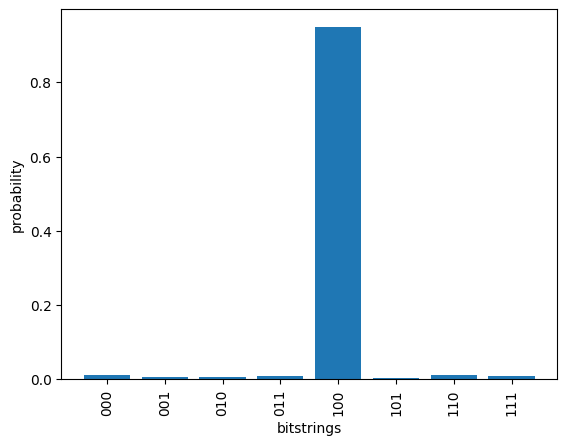

In [13]:
# Select item to find
item = "100"

# get Grover circuit
circ = grover(item, n_reps=2)

# print circuit
print(circ)

# Measurement
counts = get_result(circ)

__DISCUSSION__: We observed how repeated application of the Grover operator has amplified the occurrence of the desired bitstring, while further suppressing wrong answers to our search problem. We get the correct result with high probability.  

## Device: IonQ <a name="ionq"></a>

Finally, we check whether this scheme works on quantum hardware, by submitting our circuit to the IonQ device. To achieve this check, we first need to express the ```CCZ``` gate in terms of the native gate set of IonQ. In doing so, we build a custom gate that can be registered as a subroutine and then used as if it were any other native quantum gate within our SDK.

In [ ]:
# Set up a QPU device
device = AwsDevice(Devices.IonQ.Harmony)

In [15]:
# get device name
device_name = device.name
# show the properties of the device
device_properties = device.properties
# show supportedQuantumOperations (supported gates for a device)
device_operations = device_properties.dict()['action']['braket.ir.jaqcd.program']['supportedOperations']
# Note: This field also exists for other devices like the QPUs
print('Quantum Gates supported by {}:\n {}'.format(device_name, device_operations))

Quantum Gates supported by StateVectorSimulator:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cv', 'cy', 'cz', 'ecr', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']


For the 𝑁=8 Grover demonstration with three qubits shown in Figgatt et al. (2017), we need to implement the Controlled-Controlled-Z ```CCZ``` gate that is not natively provided on the IonQ device. We will construct this gate using native gates only such as ```CNOT``` and ```T```. Apart from our implementation, other alternative options are available (see [1] and references therein).

In [23]:
@circuit.subroutine(register=True)
def CCNot(controls=[0, 1], target=2):
    """
    build CCNOT from H, CNOT, T, Ti
    """
    cQb1, cQb2 = controls
    circ = Circuit().h(target).cnot(cQb2,target).ti(target).cnot(cQb1,target).t(target).cnot(cQb2,target).ti(target).cnot(cQb1,target).t(target).h(target).t(cQb2).cnot(cQb1,cQb2).t(cQb1).ti(cQb2).cnot(cQb1,cQb2)

    return circ

def CCZ_ionq(controls=[0, 1], target=2):
    """
    build CCZ from H and CCNOT
    """
    circ = Circuit().h(target).CCNot(controls, target).h(target)
    return circ

ccz_ionq = CCZ_ionq()

Following are oracles defined based on target items:

In [24]:
# Four possible items and their corresponding oracles
oracle_ionq = {"000": Circuit().x([0,1,2]).add(ccz_ionq).x([0,1,2]),
               "001": Circuit().x([0,1]).add(ccz_ionq).x([0,1]),
               "010": Circuit().x([0,2]).add(ccz_ionq).x([0,2]),
               "011": Circuit().x([0]).add(ccz_ionq).x([0]),
               "100": Circuit().x([1,2]).add(ccz_ionq).x([1,2]),
               "101": Circuit().x([1]).add(ccz_ionq).x([1]),
               "110": Circuit().x([2]).add(ccz_ionq).x([2]),
               "111": Circuit().add(ccz_ionq)
          }

In [25]:
# Select some example item to find
item = "111"

Same as with the classical simulator, we first initialize the qubits by applying the Hadamard gate ```H``` to every qubit.

In [26]:
# Initialize with superposition
circ = Circuit();
circ.h(np.arange(3))
print(circ)

T  : │  0  │
      ┌───┐ 
q0 : ─┤ H ├─
      └───┘ 
      ┌───┐ 
q1 : ─┤ H ├─
      └───┘ 
      ┌───┐ 
q2 : ─┤ H ├─
      └───┘ 
T  : │  0  │


Next, we apply the phase oracle corresponding to our target item.


In [27]:
# Construct phase oracle
circ.add_circuit(oracle_ionq[item])
print(circ)

T  : │  0  │  1  │  2  │  3  │  4   │  5  │  6  │  7  │  8   │  9  │ 10  │  11  │ 12  │
      ┌───┐                                                               ┌───┐        
q0 : ─┤ H ├────────────────────────────●────────────────────────●─────●───┤ T ├────●───
      └───┘                            │                        │     │   └───┘    │   
      ┌───┐                            │               ┌───┐    │   ┌─┴─┐ ┌────┐ ┌─┴─┐ 
q1 : ─┤ H ├───────────────●────────────┼───────────●───┤ T ├────┼───┤ X ├─┤ Ti ├─┤ X ├─
      └───┘               │            │           │   └───┘    │   └───┘ └────┘ └───┘ 
      ┌───┐ ┌───┐ ┌───┐ ┌─┴─┐ ┌────┐ ┌─┴─┐ ┌───┐ ┌─┴─┐ ┌────┐ ┌─┴─┐ ┌───┐ ┌───┐  ┌───┐ 
q2 : ─┤ H ├─┤ H ├─┤ H ├─┤ X ├─┤ Ti ├─┤ X ├─┤ T ├─┤ X ├─┤ Ti ├─┤ X ├─┤ T ├─┤ H ├──┤ H ├─
      └───┘ └───┘ └───┘ └───┘ └────┘ └───┘ └───┘ └───┘ └────┘ └───┘ └───┘ └───┘  └───┘ 
T  : │  0  │  1  │  2  │  3  │  4   │  5  │  6  │  7  │  8   │  9  │ 10  │  11  │ 12  │


To complete the circuit, we define the diffusion operator, whose job is to magnify the amplitude difference created by the oracle.

In [28]:
# Amplification
circ.h(np.arange(3))
circ.add_circuit(oracle_ionq['000'])
circ.h(np.arange(3))
print(circ)

T  : │  0  │  1  │  2  │  3  │  4   │  5  │  6  │  7  │  8   │  9  │ 10  │  11  │ 12  │ 13  │ 14  │ 15  │ 16  │ 17  │  18  │ 19  │ 20  │ 21  │  22  │ 23  │ 24  │  25  │ 26  │ 27  │ 28  │
      ┌───┐                                                               ┌───┐        ┌───┐ ┌───┐                                                               ┌───┐        ┌───┐ ┌───┐ 
q0 : ─┤ H ├────────────────────────────●────────────────────────●─────●───┤ T ├────●───┤ H ├─┤ X ├────────────────────────────●────────────────────────●─────●───┤ T ├────●───┤ X ├─┤ H ├─
      └───┘                            │                        │     │   └───┘    │   └───┘ └───┘                            │                        │     │   └───┘    │   └───┘ └───┘ 
      ┌───┐                            │               ┌───┐    │   ┌─┴─┐ ┌────┐ ┌─┴─┐ ┌───┐ ┌───┐                            │               ┌───┐    │   ┌─┴─┐ ┌────┐ ┌─┴─┐ ┌───┐ ┌───┐ 
q1 : ─┤ H ├───────────────●────────────┼───────────●───┤ T ├────┼

This circuit could potentially be optimized, as detailed in Ref.[1], but we will use this version for simplicity.

In the final step, we retrieve the probabilistic counts for our target item.
To this end, we submit our circuit to the IonQ device, by setting the device as ```AwsDevice(Devices.IonQ.Harmony)```.

This quantum task may not be executed immediately as it enters a queue for this machine.
Should we need to interrupt our kernel to work on something else, we can always recover our results using the unique ID of this quantum task, as shown in the following lines.

In [ ]:
# set up device
ionq = AwsDevice(Devices.IonQ.Harmony)

# run circuit
ionq_task = ionq.run(circ, shots=1000)

# get id and status of submitted quantum task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()
# print('ID of task:', ionq_task_id)
print('Status of task:', ionq_status)

In [ ]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) task:', status)

In [ ]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) quantum task:', status)

In [ ]:
# recover quantum task
task_load = AwsQuantumTask(arn=ionq_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) quantum task:', status)

# wait for hybrid job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    results = task_load.result()

    # get all metadata of submitted quantum task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.".format(shots, machine))

    # get measurement counts
    counts = results.measurement_counts
    print('Measurement counts:', counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values());
    plt.xlabel('bitstrings');
    plt.ylabel('counts');
    plt.tight_layout();
    plt.savefig('ionq.png', dpi=700);

elif status in ['FAILED', 'CANCELLED']:
    # print terminal message
    print('Your quantum task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your quantum task is still being processed and has not been finalized yet.')

Status of (reconstructed) quantum task: CREATED
Sorry, your quantum task is still being processed and has not been finalized yet.


The output looks relatively noisy due to decoherence and gate errors in this relatively long gate sequence. However, we can still observe a dominant peak for the target item.

In summary, we have shown how to implement Grover's search algorithm on a classical simulator, as well as on the IonQ device, using simple modular building blocks. We have also demonstrated how to build custom gates outside of the basic gate set provided by the SDK, and how to register these as subroutines that can be used as if they were any other pre-defined quantum gate.

In [33]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.00 USD
